In [2]:
import psycopg2
from sqlalchemy import create_engine
import pandas as pd
import numpy as np

In [3]:
# Step 1: Install required packages (only run this once)
# !pip install psycopg2-binary sqlalchemy

# Step 2: Import necessary libraries


# Step 3: Define database connection parameters
database = "postgres"
user = "postgres"
password = "password"
host = "localhost"
port = "5432"

# Step 4: Create the connection string
connection_string = f"postgresql+psycopg2://{user}:{password}@{host}:{port}/{database}"

# Step 5: Create the engine and connect
engine = create_engine(connection_string)




In [6]:
import pandas as pd

# Load the dataset
file_path = r'C:\Users\mlhsa\Documents\AviationData.csv'

# Check if file path is correct and file exists
import os
if not os.path.exists(file_path):
    print("File not found.")
else:
    # Attempt to read the file
    try:
        aviation_data = pd.read_csv(file_path)
        #print("File loaded successfully.")
        #print("Initial data preview:")
        #print(aviation_data.head())

        # Display the first few rows of the dataset
        # Check for missing values and data types
        aviation_data.info()

        # Handle missing values (if any)
        aviation_data = aviation_data.dropna(subset=['Event_Date', 'Location','Country','Make','Model','Engine_Type','Purpose_of_Flight'])



        # Correct data types (if needed)
        aviation_data['Event_Date'] = pd.to_datetime(aviation_data['Event_Date'],format='%d/%m/%Y', errors='coerce')
        aviation_data['Publication_Date'] = pd.to_datetime(aviation_data['Publication_Date'],format='%d/%m/%Y', errors='coerce')
        #print("Data preview after datetime conversion:")
        #print(aviation_data.head())

        # Remove duplicates
        aviation_data = aviation_data.drop_duplicates()
        #print("Data preview after removing duplicates:")
        print(aviation_data.head())
        
        #Save
        cleaned_file_path = r'C:\Users\mlhsa\Documents\AviationData_clean.csv'
        aviation_data.to_csv(cleaned_file_path, index=False)

    except Exception as e:
        print(f"Error loading the file: {e}")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85963 entries, 0 to 85962
Data columns (total 32 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   rn                      85963 non-null  int64  
 1   Event_Id                85963 non-null  object 
 2   Investigation_Type      85949 non-null  object 
 3   Accident_Number         85963 non-null  object 
 4   Event_Date              85963 non-null  object 
 5   Location                85885 non-null  object 
 6   Country                 85456 non-null  object 
 7   Latitude                31574 non-null  float64
 8   Longitude               31565 non-null  float64
 9   Airport_Code            48519 non-null  object 
 10  Airport_Name            51206 non-null  object 
 11  Injury_Severity         84983 non-null  object 
 12  Aircraft_Damage         82096 non-null  object 
 13  Aircraft_Category       28257 non-null  object 
 14  Registration_Number     80733 non-null

In [80]:
from sqlalchemy import MetaData, Table, Column, Integer, String, Numeric, Date

# Define metadata
metadata = MetaData()

# Define the table
aviation_data = Table('aviation_data', metadata,
    Column('rn', Integer, primary_key=True),
    Column('Event_Id', String(20)),
    Column('Investigation_Type', String),
    Column('Accident_Number', String(20)),
    Column('Event_Date', Date),
    Column('Location', String),
    Column('Country', String),
    Column('Latitude', Numeric),
    Column('Longitude', Numeric),
    Column('Airport_Code', String),
    Column('Airport_Name', String),
    Column('Injury_Severity', String),
    Column('Aircraft_Damage', String),
    Column('Aircraft_Category', String),
    Column('Registration_Number', String),
    Column('Make', String),
    Column('Model', String),
    Column('Amateur_Built', String),
    Column('Number_of_Engines', Integer),
    Column('Engine_Type', String),
    Column('FAR_Description', String),
    Column('Schedule', String),
    Column('Purpose_of_Flight', String),
    Column('Air_Carrier', String),
    Column('Total_Fatal_Injuries', Integer),
    Column('Total_Serious_Injuries', Integer),
    Column('Total_Minor_Injuries', Integer),
    Column('Total_Uninjured', Integer),
    Column('Weather_Condition', String),
    Column('Broad_Phase_of_Flight', String),
    Column('Report_Status', String),
    Column('Publication_Date', Date)
)

# Create all tables
metadata.create_all(engine)


In [7]:
#Import AviationData_clean to postgresql

table_name = 'aviation_data'

aviation_data.to_sql(table_name, engine, if_exists='replace', index=False)

97

### Some basic queries before we delve into more details.

In [17]:
# Basic Stats
sql_query = """SELECT 
COUNT(*) AS total_records,
COUNT(DISTINCT "Event_Id") AS unique_events,
CAST(MIN("Event_Date") AS DATE) AS earliest_event, 
CAST(MAX("Event_Date") AS DATE) AS latest_event  
FROM aviation_data;"""
           
df=pd.read_sql_query(sql_query,engine)
print(df.head().to_string(index=False))


 total_records  unique_events earliest_event latest_event
         77097          76112     1948-10-24   2020-05-03


In [19]:
#Distribution of events over the years
sql_query = """SELECT 
EXTRACT(YEAR FROM "Event_Date") AS year, 
COUNT(*) AS events_count
FROM aviation_data
GROUP BY year
ORDER BY year DESC;"""
           
df=pd.read_sql_query(sql_query,engine)
print(df.head().to_string(index=False))


  year  events_count
2020.0           197
2019.0          1111
2018.0          1242
2017.0          1236
2016.0          1283


In [21]:
#Most common event types
sql_query = """SELECT 
"Investigation_Type", 
COUNT(*) AS count
FROM aviation_data
GROUP BY "Investigation_Type"
ORDER BY count DESC
LIMIT 10;"""
           
df=pd.read_sql_query(sql_query,engine)
print(df.head().to_string(index=False))


Investigation_Type  count
          Accident  75196
          Incident   1901


In [5]:
#Analysis by location & their ranking
sql_query = """
SELECT 
	"Location",
	COUNT(*) AS events_count,
    DENSE_RANK() OVER (ORDER BY COUNT(*) DESC) AS rank
FROM aviation_data
GROUP BY "Location"
ORDER BY rank
LIMIT 10;
"""
           
df=pd.read_sql_query(sql_query,engine)
print(df.head().to_string(index=False))

       Location  events_count  rank
  ANCHORAGE, AK           370     1
      MIAMI, FL           183     2
    CHICAGO, IL           165     3
ALBUQUERQUE, NM           165     3
    HOUSTON, TX           155     4


In [26]:
#Incidents by phase of flight

sql_query = """SELECT "Broad_Phase_of_Flight", 
	COUNT(*) AS events_count
FROM aviation_data
GROUP BY "Broad_Phase_of_Flight"
ORDER BY events_count DESC
LIMIT 10;"""
           
df=pd.read_sql_query(sql_query,engine)
print(df.head().to_string(index=False))

Broad_Phase_of_Flight  events_count
              LANDING         19810
              TAKEOFF         15489
               CRUISE         10462
          MANEUVERING         10025
             APPROACH          7652


### Slowly going into more complex queries.

In [24]:
#Most common aircraft involved in events

sql_query = """SELECT 
"Aircraft_Category", 
COUNT(*) AS events_count
FROM aviation_data
GROUP BY "Aircraft_Category"
ORDER BY events_count DESC
LIMIT 10;"""
           
df=pd.read_sql_query(sql_query,engine)
print(df.head().to_string(index=False))

Aircraft_Category  events_count
             None         53771
         Airplane         20547
       Helicopter          2294
           Glider           127
     Weight-Shift            94


In [25]:
#Events involving multiple aircraft

sql_query = """SELECT "Event_Id",
		"Location",
		"Purpose_of_Flight",
		COUNT(DISTINCT "Aircraft_Category") AS aircraft_count,
		ARRAY_AGG(DISTINCT "Aircraft_Category") AS aircraft_types
FROM aviation_data
GROUP BY "Event_Id", "Location", "Purpose_of_Flight"
HAVING COUNT(DISTINCT "Aircraft_Category") > 1
ORDER BY aircraft_count DESC;
"""
           
df=pd.read_sql_query(sql_query,engine)
print(df.head().to_string(index=False))

      Event_Id            Location Purpose_of_Flight  aircraft_count         aircraft_types
20020917X04592            KATY, TX           Unknown               2     [Airplane, Glider]
20110830X71207     Mt. Clemens, MI     Air Race/Show               2 [Airplane, Helicopter]
20120220X14409         Antioch, CA          Personal               2 [Airplane, Helicopter]
20150129X05038 West Palm Beach, FL     Instructional               2 [Airplane, Helicopter]
20150810X83147       Istra, Russia           Unknown               2 [Airplane, Helicopter]


In [6]:
#Analyzing total fatal injuries by phase of flight using CTEs

sql_query = """
WITH fatal_injuries AS (
    SELECT 
	"Broad_Phase_of_Flight", 
	SUM("Total_Fatal_Injuries") AS total_fatal_injuries
FROM aviation_data
GROUP BY "Broad_Phase_of_Flight"
)
SELECT 
	"Broad_Phase_of_Flight", 
	total_fatal_injuries
FROM fatal_injuries
ORDER BY total_fatal_injuries DESC;
"""
           
df=pd.read_sql_query(sql_query,engine)
print(df.head().to_string(index=False))

Broad_Phase_of_Flight  total_fatal_injuries
          MANEUVERING                6449.0
                 None                6194.0
               CRUISE                6042.0
              TAKEOFF                4986.0
             APPROACH                4386.0


In [7]:
#Deaths & Injuries in the last decade

sql_query = """
SELECT 
	EXTRACT(YEAR FROM "Event_Date") "Year",
	SUM("Total_Fatal_Injuries") "Total Deaths",
	SUM("Total_Serious_Injuries") "Total Serious Injuries"
FROM aviation_data
WHERE EXTRACT(YEAR FROM "Event_Date") >= (EXTRACT(YEAR FROM CURRENT_DATE) -14)
GROUP BY 1
ORDER BY 1 DESC;

"""
           
df=pd.read_sql_query(sql_query,engine)
print(df.head().to_string(index=False))

  Year  Total Deaths  Total Serious Injuries
2020.0          66.0                    27.0
2019.0         370.0                   183.0
2018.0         365.0                   218.0
2017.0         362.0                   199.0
2016.0         418.0                   193.0


In [13]:
sql_query=("SELECT * FROM aviation_data")
df=pd.read_sql_query(sql_query,engine)

In [15]:
print(df['rn'])

0            1
1            2
2            3
3            4
4            7
         ...  
77092    84972
77093    84973
77094    84977
77095    84978
77096    84980
Name: rn, Length: 77097, dtype: int64


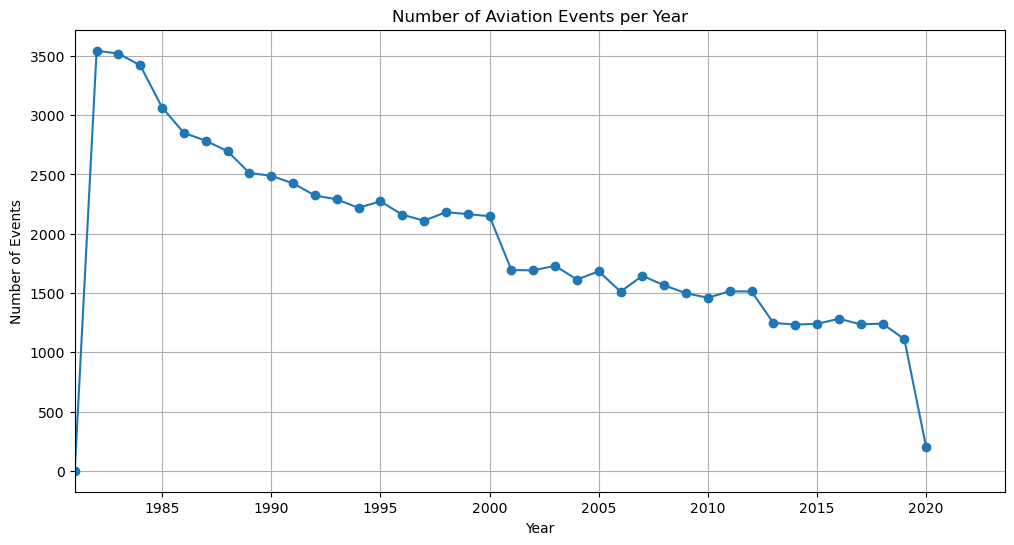

In [25]:
import matplotlib.pyplot as plt

# Visualize distribution of events over the years
df['year'] = df['Event_Date'].dt.year
events_per_year = df['year'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
plt.plot(events_per_year.index, events_per_year.values, marker='o')
plt.title('Number of Aviation Events per Year')
plt.xlabel('Year')
plt.xlim(left=1981)
plt.ylabel('Number of Events')
plt.grid(True)
plt.show()



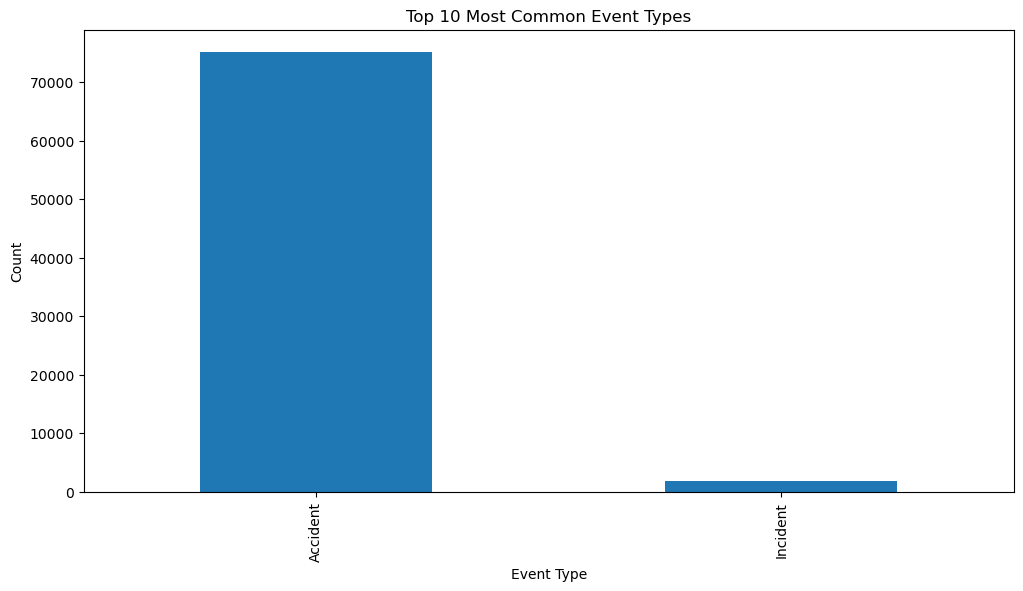

In [26]:
# Visualize most common event types
event_types = df['Investigation_Type'].value_counts().head(10)

plt.figure(figsize=(12, 6))
event_types.plot(kind='bar')
plt.title('Top 10 Most Common Event Types')
plt.xlabel('Event Type')
plt.ylabel('Count')
plt.show()


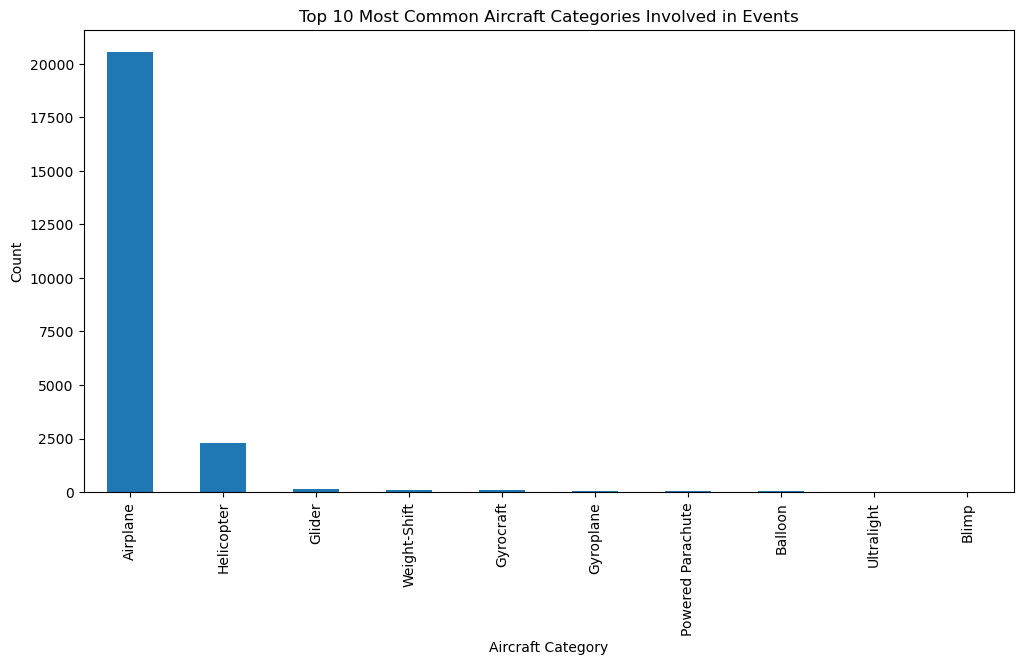

In [27]:
# Visualize the most common aircraft categories
aircraft_categories = df['Aircraft_Category'].value_counts().head(10)

plt.figure(figsize=(12, 6))
aircraft_categories.plot(kind='bar')
plt.title('Top 10 Most Common Aircraft Categories Involved in Events')
plt.xlabel('Aircraft Category')
plt.ylabel('Count')
plt.show()


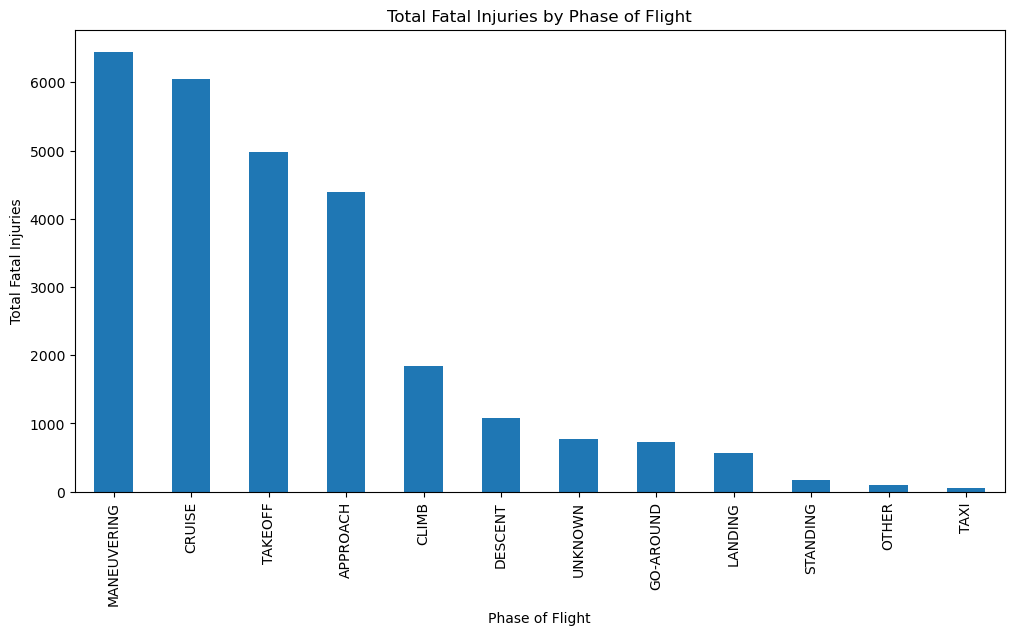

In [28]:
# Visualize fatal injuries by phase of flight
phase_of_flight = df.groupby('Broad_Phase_of_Flight')['Total_Fatal_Injuries'].sum().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
phase_of_flight.plot(kind='bar')
plt.title('Total Fatal Injuries by Phase of Flight')
plt.xlabel('Phase of Flight')
plt.ylabel('Total Fatal Injuries')
plt.show()